In [1]:
import matplotlib.pyplot as plt
import json
import itertools
import pandas as pd
import numpy as np

In [2]:
with open('results.json') as f:
    data = json.load(f)
    
data_list = []

for run_idx, run in enumerate(data):
    for planner_run in run['planner_runs']:
        data_list.append({
            'run_idx': run_idx,
            'apples': run['number_of_apples'],
            **planner_run
        })
            
data_df = pd.DataFrame(data_list).sort_values('run_idx')
data_df['mean_per_target_path_length'] = data_df.total_path_length / data_df.apples
data_df = data_df.set_index(['run_idx','intermediate_planner','order_planning', 'optimization_objective','sampler','runtime_budget'])
experiment_variables = ['intermediate_planner','order_planning', 'optimization_objective','sampler','runtime_budget']

In [3]:
[s['goal_idx'] for s in data[0]['planner_runs'][3]['segment_stats']]

[12,
 22,
 27,
 17,
 16,
 34,
 6,
 5,
 15,
 26,
 7,
 19,
 21,
 25,
 23,
 11,
 30,
 18,
 4,
 13,
 8,
 1,
 14,
 32,
 10,
 0,
 2,
 28,
 9,
 33,
 29,
 31,
 24]

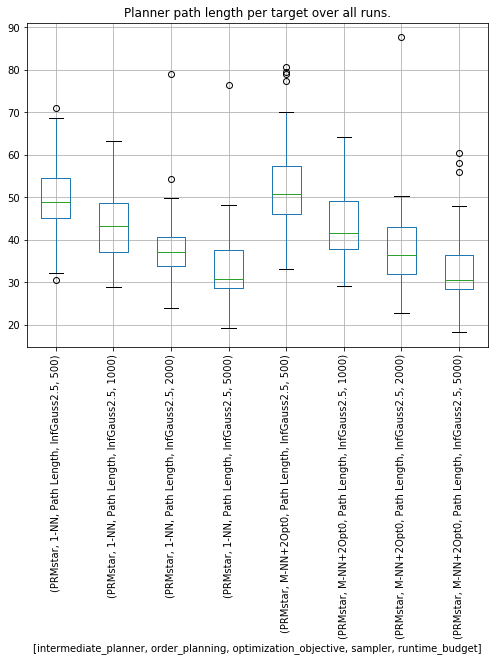

In [4]:
(data_df.total_path_length / data_df.targets_visited)\
    .to_frame()\
    .boxplot(by=experiment_variables, rot=90, figsize=(8,6))

# plt.ylim(15,90)
plt.title('Planner path length per target over all runs.')
plt.suptitle('')
plt.savefig('path_length_per_target.png')
plt.show()

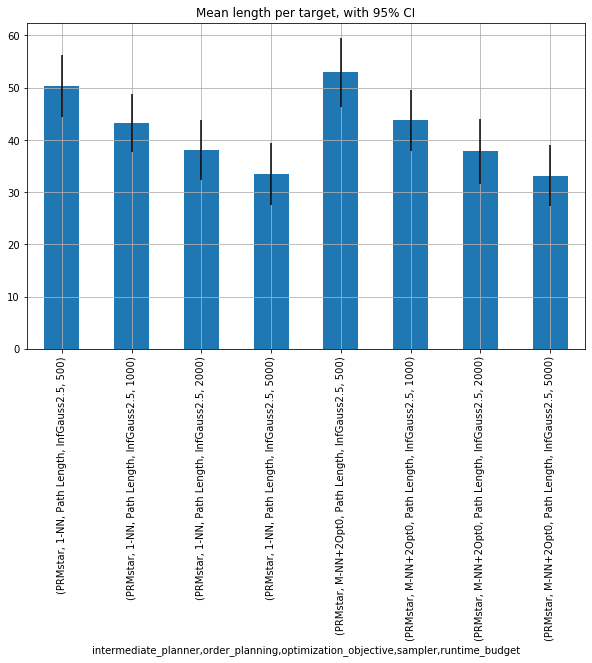

In [5]:
stats = (data_df.total_path_length / data_df.targets_visited)\
    .groupby(experiment_variables)\
    .agg(['mean','std','count'])

stats['err'] = 1.96 * stats['std'] / np.sqrt(stats['std'])

stats['mean'].plot(kind='bar', 
                   yerr=stats['err'], 
                   grid=True, 
#                    ylim=(20,40), 
                   title='Mean length per target, with 95% CI',
                   figsize=(10,6))

#     .boxplot(by=experiment_variables, rot=90, figsize=(8,6))

# plt.ylim(15,50)
# plt.title('Planner path length per target')
# plt.suptitle('')
# plt.savefig('path_length_per_target.png')
# plt.show()

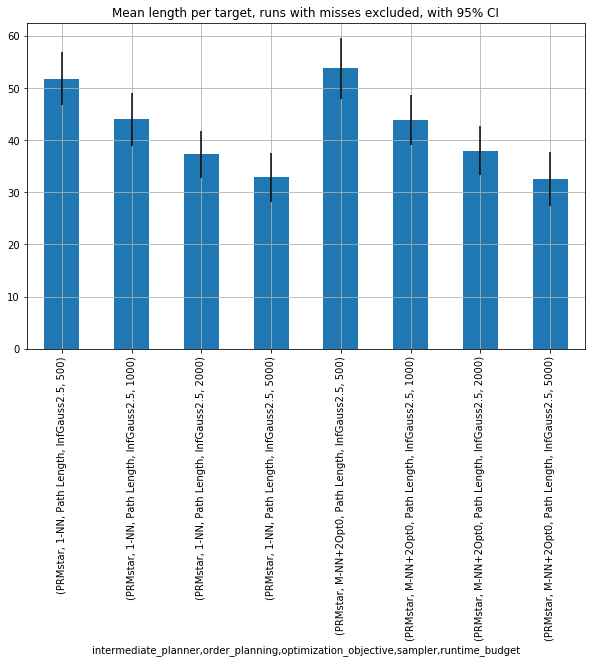

In [6]:
bad_runs = set(data_df[(data_df.targets_visited < data_df.apples) & (data_df.index.get_level_values('runtime_budget') == 5000)].index.get_level_values('run_idx'))
clean_df = data_df[data_df.index.get_level_values('run_idx').isin(bad_runs)]
# TODO: Try to see if it's better for perfect runs.

stats = (clean_df.total_path_length / clean_df.targets_visited)\
    .groupby(experiment_variables)\
    .agg(['mean','std','count'])

stats['err'] = 1.96 * stats['std'] / np.sqrt(stats['std'])

stats['mean'].plot(kind='bar', 
                   yerr=stats['err'], 
                   grid=True, 
#                    ylim=(20,40), 
                   title='Mean length per target, runs with misses excluded, with 95% CI',
                   figsize=(10,6))

#     .boxplot(by=experiment_variables, rot=90, figsize=(8,6))

# plt.ylim(15,50)
# plt.title('Planner path length per target')
# plt.suptitle('')
# plt.savefig('path_length_per_target.png')
# plt.show()

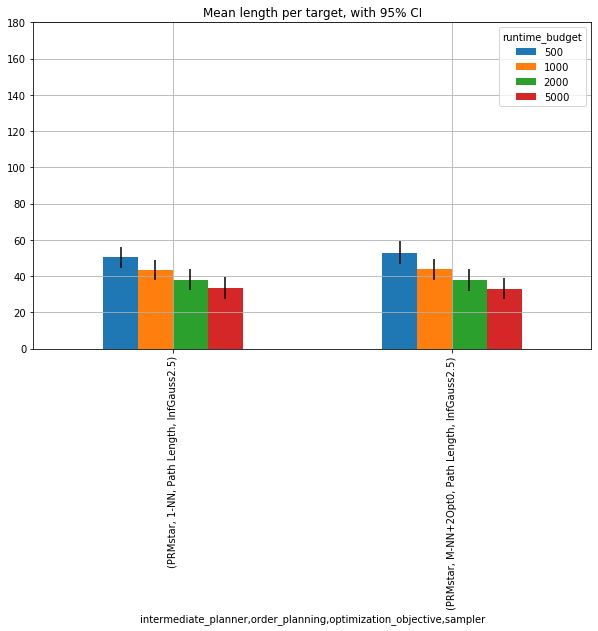

In [7]:
stats = (data_df.total_path_length / data_df.targets_visited)\
    .groupby(experiment_variables)\
    .agg(['mean','std','count'])

stats['err'] = 1.96 * stats['std'] / np.sqrt(stats['std'])

stats = stats.sort_index(level='runtime_budget')
# stats = stats.unstack('runtime_budget')

stats = stats[['err','mean']].unstack('runtime_budget')

stats['mean'].plot(kind='bar', 
                   yerr=stats['err'], 
                   grid=True, 
                   ylim=(0,180), 
                   title='Mean length per target, with 95% CI',
                   figsize=(10,6))

#     .boxplot(by=experiment_variables, rot=90, figsize=(8,6))



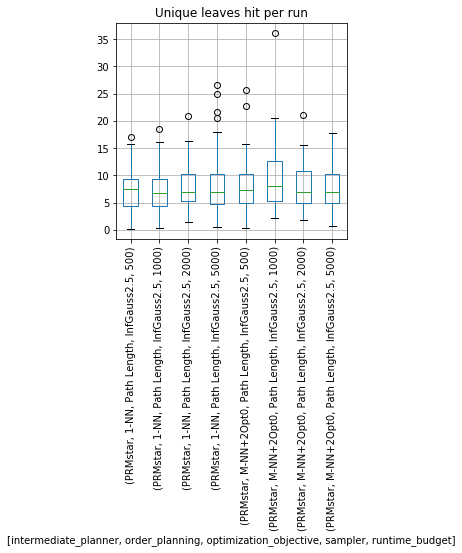

In [8]:
(data_df.unique_leaves_collided / data_df.targets_visited)\
    .to_frame()\
    .boxplot(by=experiment_variables, rot=90, figsize=(4,4))

plt.title('Unique leaves hit per run')
plt.suptitle('')
plt.savefig('leaves_hit_per_target.png')
plt.show()

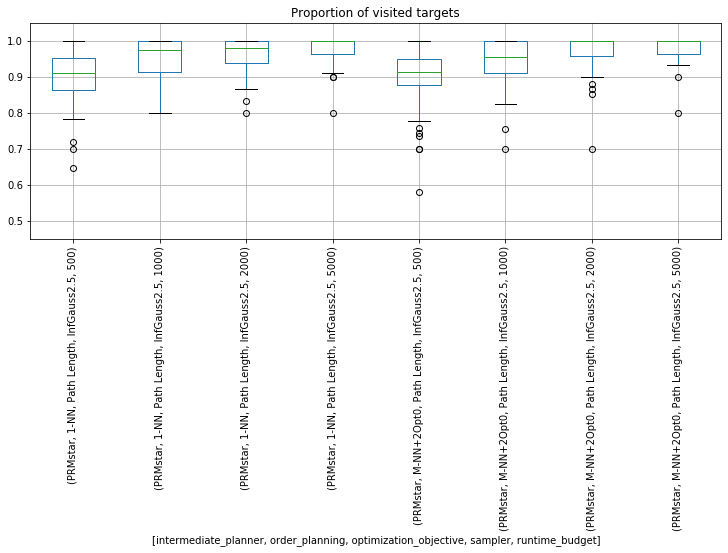

In [9]:
(data_df.targets_visited/ data_df.apples)\
    .to_frame()\
    .boxplot(by=experiment_variables, rot=90, figsize=(12,4))

plt.ylim(0.45,1.05)
plt.title('Proportion of visited targets')
plt.suptitle('')
plt.savefig('proportion_visited_targets.png')
plt.show()

In [10]:
size(bad_runs)

NameError: name 'size' is not defined

In [ ]:
data_df.loc[]

In [ ]:
ptp_list = []

for run_idx, run in enumerate(data):
    for planner_run in run['planner_runs']:
        for (seg_i,seg) in enumerate(planner_run['segment_stats']):
            ptp_list.append({
                'run_idx': run_idx,
                'seg_idx': seg_i,
                'apples': run['number_of_apples'],
                **dict((v,planner_run[v]) for v in experiment_variables),
                **seg
            })

ptp_df = pd.DataFrame(ptp_list).set_index(experiment_variables+['run_idx','seg_idx','apples'])

In [ ]:
df.index.get_level_values('sample')

In [ ]:
for (tm,grp) in ptp_df[ptp_df.index['sampler']=='uniform'].groupby(['runtime_budget','sampler']):
    grp.groupby('seg_idx').length.mean().plot(title=str(tm),figsize=(14,10))

In [ ]:
length_bins = np.linspace(0,200,10)

# ptp_df[ptp_df['order_planning'] == '1-NNProb2OPT'].length.hist(bins=length_bins)

ptp_sub = ptp_df[ptp_df['sampler'] == 'uniform']

ptp_sub.groupby(['order_planning',pd.cut(ptp_sub.length, length_bins)]).sum().length.plot(rot=90,kind='bar',grid=True, figsize=(10,6))